# Text Classification: Word2Vec

In this notebook, I demonstrate how to create and train a **Word2Vec** model in order to identify similarities for hard and soft skills from job post descriptions.

## Table of contents

1. [Environment](#Environment)
   1. [Imports and Datasets](#Imports-and-Datasets)
   2. [Noun Chunk Extraction](#Noun-Chunk-Extraction)
   3. [Dataset Preparation](#Dataset-Preparation)
   4. [Text Encoder](#Text-Encoder)
2. [Model and Training](#Model-and-Training)
   1. [Configuration](#Configuration)
   2. [Training Dataset](#Training-Dataset)
   3. [Training](#Training)
3. [Results and Visualizations](#Results-and-Visualizations)
   1. [Embedding Vectors](#Embedding-Vectors)
   2. [Wordcloud Visualizations](#Wordcloud-Visualizations)

## Environment

### Imports and Datasets

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import io
import random
import numpy as np
from numpy.linalg import norm
import pandas as pd                # Data processing
import tqdm                        # Easy loading bar

# Visualization imports
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline
from wordcloud import WordCloud    # Wordcloud visualizations

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

# Database imports
from modeling.database import MongoDB

# NLP imports
import spacy

Let's load the complete dataset from the MongoDB connection.

In [3]:
db = MongoDB()
df = pd.DataFrame(list(db.get_all_documents()))

### Noun Chunk Extraction

In [4]:
nlp = spacy.load("en_core_web_sm")

noun_phrases = []
for doc in nlp.pipe(df['description'].astype('unicode').values, batch_size=50, n_process=6):
    assert doc.has_annotation("DEP")
    for chunk in doc.noun_chunks:
        noun_phrases.append(chunk.text)

# Swap the following so that the set does not include duplicate phrases
#nouns_phrases_set = list(set(noun_phrases))
nouns_phrases_set = list(noun_phrases)

df = pd.DataFrame(nouns_phrases_set, columns=["chunks"])
print(f'Amount of noun chunks extracted: {len(df)}')

Amount of noun chunks extracted: 37201


In [5]:
print('Maximum phrase length:\t', df['chunks'].str.split().str.len().max())

Maximum phrase length:	 18


### Dataset Preparation

In [6]:
text_ds = tf.data.Dataset.from_tensor_slices(df)
text_ds = text_ds.batch(1024)
next(text_ds.as_numpy_iterator())[:10]

array([[b'The Tech Team\n\nTechnology'],
       [b'everything'],
       [b'we'],
       [b'Dialectica'],
       [b'clients'],
       [b'the most relevant expert profiles'],
       [b'just a few minutes'],
       [b'indexing'],
       [b'thousands'],
       [b'pieces']], dtype=object)

### Text Encoder

In [7]:
# Custom standardization function to strip remove uneccessary text and symbols.
def custom_standardization(input_data):
    input_df = tf.strings.lower(input_data)
    input_df = tf.strings.regex_replace(input_df, '(e\.g\.?)|(i\.e\.?).', '')
    input_df = tf.strings.regex_replace(input_df, '[^\u0020-\u007E]', ' ')
    input_df = tf.strings.regex_replace(input_df, '\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b', '')
    input_df = tf.strings.regex_replace(input_df, '(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '')
    input_df = tf.strings.regex_replace(input_df, '\B#([a-z0-9]{1,})', ' ')
    input_df = tf.strings.regex_replace(input_df, '[^\w\s+#]', ' ')
    
    return tf.strings.regex_replace(input_df, '(\s{2,})|(\n+)', ' ')

In [8]:
# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 18

# Use the `TextVectorization` layer to normalize, split, and map strings to integers.
# Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(text_ds)

In [9]:
vocabulary = np.array(vectorize_layer.get_vocabulary())
print('Vocabulary size: {}'.format(len(vocabulary)))

num = random.randint(1, len(vocabulary))
print(f"Word with number {num} represents -->", vocabulary[num])

Vocabulary size: 4096
Word with number 3784 represents --> escalated


In [10]:
example = next(text_ds.as_numpy_iterator())[0]
encoded_example = vectorize_layer(example).numpy()
print('Noun Chunk:\t', example)
print('Encoded:\t', encoded_example)

Noun Chunk:	 [b'The Tech Team\n\nTechnology']
Encoded:	 [[  2 151  12  26   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [11]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:10])

['', '[UNK]', 'the', 'data', 'a', 'you', 'our', 'and', 'we', 'experience']


In [12]:
# Vectorize the data in text_ds.
text_vector_ds = text_ds.prefetch(tf.data.AUTOTUNE).map(vectorize_layer).unbatch()

In [13]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(f'Amount of vectorized data sequences: {len(sequences)}')

Amount of vectorized data sequences: 37201


In [14]:
for seq in sequences[:3]:
    print('Noun Chunk:\t', [inverse_vocab[i] for i in seq])
    print('Encoded:\t', seq)

Noun Chunk:	 ['the', 'tech', 'team', 'technology', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Encoded:	 [  2 151  12  26   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Noun Chunk:	 ['everything', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Encoded:	 [1217    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
Noun Chunk:	 ['we', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Encoded:	 [8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Model and Training

`Word2vec` is a family of algorithms that let us learn and train word embeddings from a corpus. One way of learning vector represantation of words is called `continuous skip-gram model`. This model predicts the words around the word currently being searched. The amount of words to be searched has a certain range which we specify.

In this model the first thing is to generate the positive-skip grams for each word. Positive in the sense that the neightborhood of the word includes words that appear within the specified range or window. After this we will have to find also the negative sampling for skip-gram generation. These are the pairs of the current word and an amount of words that do not appear within our specified window. The steps we need to encode are the following:

1. Generate positive skip-grams
2. Perform negative sampling for each skip-gram

### Configuration

In [15]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for `vocab_size` tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in the dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        # Iterate over each positive skip-gram pair to produce training examples
        # with a positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
            tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling"
            )

            # Build context and label vectors (for one target word)
            context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [16]:
num_ns = 15

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=0
)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print(f"\ntargets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████████████████████████████████████████████████████████████████████| 37201/37201 [00:09<00:00, 3822.37it/s]



targets.shape: (15249,)
contexts.shape: (15249, 16)
labels.shape: (15249, 16)


### Training Dataset

In [17]:
BATCH_SIZE = 1024
BUFFER_SIZE = 5000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

### Training

In [18]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding  = Embedding(vocab_size, embedding_dim, input_length=1, name="w2v_embedding")
        self.context_embedding = Embedding(vocab_size, embedding_dim, input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [19]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [20]:
NUM_EPOCHS = 40
history = word2vec.fit(dataset, epochs=NUM_EPOCHS)

Epoch 1/40
14/14 [==============================] - 1s 28ms/step - loss: 2.7703 - accuracy: 0.1198
Epoch 2/40
14/14 [==============================] - 0s 26ms/step - loss: 2.7545 - accuracy: 0.4941
Epoch 3/40
14/14 [==============================] - 0s 30ms/step - loss: 2.7370 - accuracy: 0.7079
Epoch 4/40
14/14 [==============================] - 0s 29ms/step - loss: 2.7137 - accuracy: 0.7866
Epoch 5/40
14/14 [==============================] - 0s 32ms/step - loss: 2.6813 - accuracy: 0.8100
Epoch 6/40
14/14 [==============================] - 0s 35ms/step - loss: 2.6369 - accuracy: 0.8128
Epoch 7/40
14/14 [==============================] - 0s 34ms/step - loss: 2.5782 - accuracy: 0.8094
Epoch 8/40
14/14 [==============================] - 1s 39ms/step - loss: 2.5038 - accuracy: 0.8041
Epoch 9/40
14/14 [==============================] - 0s 34ms/step - loss: 2.4137 - accuracy: 0.7988
Epoch 10/40
14/14 [==============================] - 0s 35ms/step - loss: 2.3093 - accuracy: 0.7962
Epoch 11/

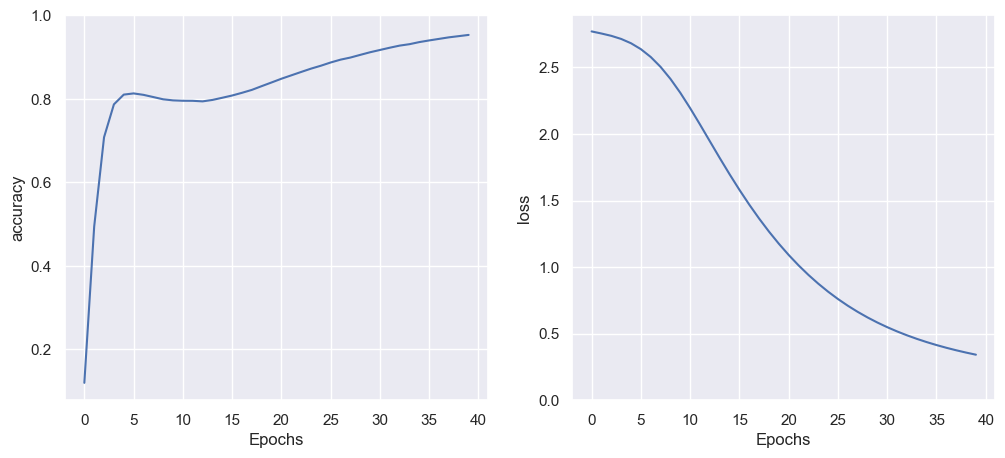

In [21]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

plt.show()

## Results and Visualizations

### Embedding Vectors

In [22]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

inverse_voc = {}
for index, word in enumerate(vocabulary):
    inverse_voc[word] = index

In [23]:
# Function that accepts a word and returns the num most similar words to the given one
def most_similar(word, num):
    similar = []
    word_w = weights[inverse_voc[word]]
    for key, value in inverse_voc.items():
        if word == key:
            continue
        cosine = np.dot(word_w, weights[inverse_voc[key]])/(norm(word_w)*norm(weights[inverse_voc[key]]))
        similar.append((key, cosine))
        
    similar.sort(key=lambda x: x[1], reverse=True)
    #similar = sorted(similar, key=float, reverse=True)
        
    return similar[:num]

In [24]:
pd.DataFrame(most_similar("python", 10), columns=['Word', 'Similarity'])

,Word,Similarity
0,julia,0.616347
1,kotlin,0.590441
2,programming,0.465668
3,speech,0.465458
4,scaled,0.465250
5,image,0.456674
6,funded,0.441260
7,build,0.433120
8,r,0.433114
9,changes,0.411964


In [25]:
out_v = io.open('embeddings/w2v_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('embeddings/w2v_metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocabulary):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

The exported model's weights and metadata can be used to visualize the vector space here: http://projector.tensorflow.org/

### Wordcloud Visualizations

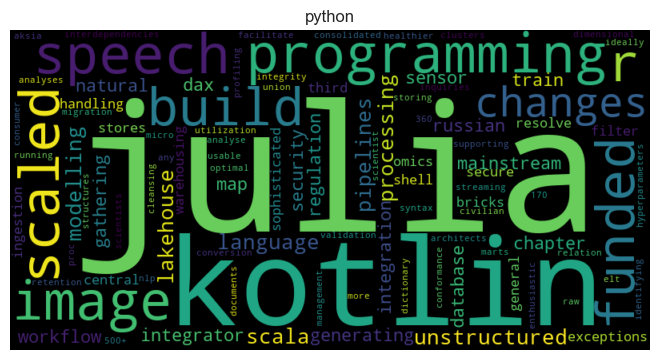

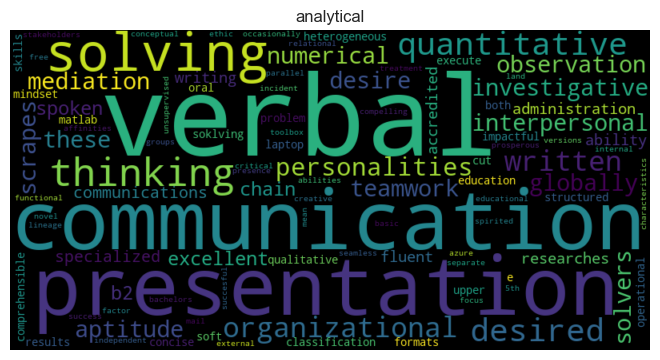

In [26]:
for category in ['python', 'analytical']:
    text = {x[0]: x[1] for x in most_similar(category, 100)}
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(text)

    # Display wordcloud graphic
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()